In [1]:
import joblib
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from collections import defaultdict
from glob import glob
from scipy.stats import iqr
from numpy import median
import json

## Visualization 

1. Step 1. For all T0 related datasets: `t03b_realsumm_2class_split_*` compute correlation w/ human judgements.
    - This involves merging w/ original realsumm data. 
    - We can use the `dev_preds.txt` and also the `test.csv` we created for this.
    
    

In [28]:
def compute_metrics(df, human_col, corr_cols=None):
    from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
    from scipy.stats import pearsonr, spearmanr, kendalltau
    
    metrics = {}
    
    kwargs = {"y_true": df['label'], "y_pred": df["pred"], "labels": ["No", "Yes"], "pos_label": "Yes"}
    metrics["precision"] = precision_score(**kwargs)
    metrics["recall"] = recall_score(**kwargs)
    
    kwargs.pop("pos_label")
    tn, fp, fn, tp = confusion_matrix(**kwargs).ravel()
    
    metrics["tn"] = tn
    metrics["fp"] = fp
    metrics["fn"] = fn
    metrics["tp"] = tp
    metrics["n"] = len(df)
    
    kwargs.pop("labels")
    metrics["accuracy"] = accuracy_score(**kwargs)
    
    if "log.label_score" in df.columns and "log.pred_score" in df.columns:
        scores = np.where(
            df['label']=="Yes", 
            # if true
            df["log.label_score"], 
            # else
            df["log.pred_score"]
        )#np.where(df["pred"] == "Yes" , df["log.label_score"], df["log.pred_score"]))
    
        # TODO - Update scores: should belong to same class
        # scores = np.exp(-scores) # TODO - PERHAPS NORMALIZING THE TWO
        
        metrics[f"pearson_ia3"] = pearsonr(scores, df[human_col])[0]
        metrics[f"spearman_ia3"] = spearmanr(scores, df[human_col])[0]
        metrics[f"kendaltau_ia3"] = kendalltau(scores, df[human_col])[0]
        
        for col in corr_cols:
            metrics[f"pearson_{col}"] = pearsonr(df[col], df[human_col])[0]
            metrics[f"spearman_{col}"] = spearmanr(df[col], df[human_col])[0]
            metrics[f"kendaltau_{col}"] = kendalltau(df[col], df[human_col])[0]
    
    return metrics
        

def get_num_shot(filepath):
    for i in (256, 128, 64, 32, 16, 8, 4, 1):
        if f"shots{i}_" in filepath:
            return i
    raise ValueError(filepath)
    
def get_split_seed(filepath):
    for i in (42, 4649, 91238):
        if f"split{i}_" in filepath:
            return i
    raise ValueError(filepath)
    
    
def get_k_seed(filepath):
    for i in (42, 0, 1024):
        if f"seed{i}_" in filepath:
            return i
    else:
        raise ValueError(filepath)

In [29]:
LANGUAGE_PAIR = "de-en"

mt_final_results = joblib.load(f"./experiments/mt_data/{LANGUAGE_PAIR}/final_p.pkl")
metrics = ["bleu", "bart_score_cnn", "bart_score_para", "bert_score","prism", "bleurt", "chrf"]

test_files = {i: f"./experiments/mt_data/{LANGUAGE_PAIR}/split_{i}/2class_test.csv" for i in (42, 4649, 91238)}
test_files = {i: pd.read_csv(f) for i, f in test_files.items()}

test_files_results = {}
for k, test_file in test_files.items():
    results = []
    for ix, row in test_file.iterrows():
        doc_data = mt_final_results[row["_orig_id"]]

        if row["src"] != doc_data["src"]:
            raise ValueError()
        elif row["ref"] != doc_data["ref"]:
            raise ValueError()

        # it either belongs to the better:
        for system in (doc_data["better"], doc_data["worse"]):
            if row["sys_name"] == system["sys_name"]:
                for metric in metrics:
                    row[metric] = system["scores"][metric]
                results.append(row)
                break
        else:
            raise ValueError("No match :o")
            
    results = pd.DataFrame(results)
    print(len(results))
    for metric in metrics:
        results[metric] = results[metric].astype(float)
    test_files_results[k] = results
test_files_results[42]

5988
6011
6019


,index,Unnamed: 0,src,ref,mt,sys_name,_orig_id,lp,score,raw_score,annotators,bin,label,bleu,bart_score_cnn,bart_score_para,bert_score,prism,bleurt,chrf
0,356,356,Der Verschlüsseler notiert also und liest laut...,"The encryptor writes down and reads aloud: ""Th...","So the encryption notes and reads aloud: ""Thro...",uedin.6749,1012,de-en,-0.159303,0.6500,1,"(0.5, 1.0]",1,35.433476,-3.219908,-3.014135,0.401586,-2.601125,-0.959852,0.534905
1,357,357,Der Verschlüsseler notiert also und liest laut...,"The encryptor writes down and reads aloud: ""Th...","The encoder thus notes and reads aloud: ""Throw...",PROMT_NMT_DE-EN.6683,1012,de-en,-2.012543,0.2700,2,"(-0.001, 0.5]",0,29.814916,-3.499930,-3.137692,0.429357,-2.598245,-0.877748,0.524304
2,358,358,Der Verschlüsseler notiert also und liest laut...,"The encryptor writes down and reads aloud: ""Th...","The encrypter thus notes and reads aloud: ""thr...",RWTH_Aachen_System.6818,1013,de-en,-2.325092,0.1850,2,"(-0.001, 0.5]",0,28.161172,-3.232361,-2.873232,0.413185,-2.399510,-0.688190,0.510980
3,359,359,Der Verschlüsseler notiert also und liest laut...,"The encryptor writes down and reads aloud: ""Th...","So the encrypter notes and reads out loud: ""Th...",JHU.6809,1014,de-en,-0.183385,0.7600,1,"(0.5, 1.0]",1,26.330125,-3.420992,-3.075637,0.404528,-2.468747,-0.828744,0.502546
4,360,360,Der Verschlüsseler notiert also und liest laut...,"The encryptor writes down and reads aloud: ""Th...","So the ver noted and reads loud: "" throw "" for...",online-X.0,1014,de-en,-0.774712,0.5000,1,"(-0.001, 0.5]",0,30.822553,-3.771498,-3.525634,0.325903,-2.911923,-0.940347,0.540283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5983,30053,30053,Der Sänger sei am Sonntag im Alter von 72 Jahr...,The singer died on Sunday at the age of 72 fol...,The singer died on Sunday at the age of 72 aft...,NEU.6801,85071,de-en,0.768167,0.9240,5,"(0.5, 1.0]",1,56.032211,-0.785585,-0.848195,0.910135,-0.622228,0.874712,0.753688
5984,30054,30054,Der Sänger sei am Sonntag im Alter von 72 Jahr...,The singer died on Sunday at the age of 72 fol...,The singer died on Sunday at the age of 72 aft...,MSRA.MADL.6910,85073,de-en,0.768167,0.9240,5,"(0.5, 1.0]",1,56.032211,-0.785585,-0.848195,0.910135,-0.622228,0.874712,0.753688
5985,30055,30055,Der Sänger sei am Sonntag im Alter von 72 Jahr...,The singer died on Sunday at the age of 72 fol...,The singer died on Sunday at the age of 72 aft...,online-Y.0,85085,de-en,0.768167,0.9240,5,"(0.5, 1.0]",1,56.032211,-0.785585,-0.848195,0.910135,-0.622228,0.874712,0.753688
5986,30056,30056,Der Sänger sei am Sonntag im Alter von 72 Jahr...,The singer died on Sunday at the age of 72 fol...,The singer died on Sunday at the age of 72 aft...,online-G.0,85089,de-en,0.566438,1.0000,1,"(0.5, 1.0]",1,58.511239,-0.859719,-0.894195,0.894674,-0.600576,0.937763,0.782090


In [30]:
test_files_results[42].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5988 entries, 0 to 5987
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            5988 non-null   int64  
 1   Unnamed: 0       5988 non-null   int64  
 2   src              5988 non-null   object 
 3   ref              5988 non-null   object 
 4   mt               5988 non-null   object 
 5   sys_name         5988 non-null   object 
 6   _orig_id         5988 non-null   int64  
 7   lp               5988 non-null   object 
 8   score            5988 non-null   float64
 9   raw_score        5988 non-null   float64
 10  annotators       5988 non-null   int64  
 11  bin              5988 non-null   object 
 12  label            5988 non-null   int64  
 13  bleu             5988 non-null   float64
 14  bart_score_cnn   5988 non-null   float64
 15  bart_score_para  5988 non-null   float64
 16  bert_score       5988 non-null   float64
 17  prism         

In [31]:
def get_test_set(filepath):
    for i in (42, 4649, 91238):
        if f"split{i}" in filepath:
            return test_files_results[i]
    raise ValueError(filepath)

In [32]:
DATASET = f"wmt-{LANGUAGE_PAIR}"
HUMAN_COL = "raw_score"
OUTPUT_PATH = "t-few-master/exp_out"

if OUTPUT_PATH.endswith("no_scores"):
    COLS = ["id", "pred", "label", "pred_score", "label_score"] # no scores
else:
    COLS = ["id", "pred", "label", "log.pred_score", "log.label_score"] # w scores


EXPERIMENT_TEMPLATE = f"t03b_{DATASET}*"
all_files = glob(os.path.join(OUTPUT_PATH, EXPERIMENT_TEMPLATE, "dev_pred.txt"))
print(f"Find {len(all_files)} experiments fit into {EXPERIMENT_TEMPLATE}")


def read_file(file, human_col, cols=COLS, corr_cols=metrics):
    file_df = pd.read_csv(file)

    test_df = get_test_set(file)
    assert len(file_df) == len(test_df)

    data = file_df[cols].merge(test_df, left_on="id", right_on="index", how="inner", suffixes=(None,"_original"), validate="1:1")

    metrics = compute_metrics(data, human_col=human_col, corr_cols=corr_cols)
    metrics["num_shots"] = get_num_shot(file)
    metrics["split_seed"] = get_split_seed(file)
    metrics["shots_seed"] = get_k_seed(file)
    metrics["filepath"] = file
    return metrics


results = [read_file(f, human_col=HUMAN_COL) for f in all_files]    
results = pd.DataFrame(results)
results.head()

Find 36 experiments fit into t03b_wmt-de-en*


,precision,recall,tn,fp,fn,tp,n,accuracy,pearson_ia3,spearman_ia3,...,pearson_bleurt,spearman_bleurt,kendaltau_bleurt,pearson_chrf,spearman_chrf,kendaltau_chrf,num_shots,split_seed,shots_seed,filepath
0,0.960943,0.275749,786,58,3748,1427,6019,0.367669,-0.269889,-0.265870,...,0.398617,0.375666,0.258113,0.270007,0.254891,0.173973,64,91238,42,t-few-master/exp_out/t03b_wmt-de-en_2class_spl...
1,0.966078,0.264155,796,48,3808,1367,6019,0.359362,-0.276728,-0.268127,...,0.398617,0.375666,0.258113,0.270007,0.254891,0.173973,64,91238,1024,t-few-master/exp_out/t03b_wmt-de-en_2class_spl...
2,0.933592,0.330525,787,120,3417,1687,6011,0.411579,-0.266447,-0.272724,...,0.428636,0.389657,0.268874,0.280480,0.265371,0.181215,64,4649,0,t-few-master/exp_out/t03b_wmt-de-en_2class_spl...
3,0.953528,0.321159,763,81,3513,1662,6019,0.402891,-0.270202,-0.266475,...,0.398617,0.375666,0.258113,0.270007,0.254891,0.173973,64,91238,0,t-few-master/exp_out/t03b_wmt-de-en_2class_spl...
4,0.921782,0.332484,763,144,3407,1697,6011,0.409250,-0.260331,-0.268915,...,0.428636,0.389657,0.268874,0.280480,0.265371,0.181215,64,4649,42,t-few-master/exp_out/t03b_wmt-de-en_2class_spl...


In [33]:
results.groupby(["num_shots"]).count()

,precision,recall,tn,fp,fn,tp,n,accuracy,pearson_ia3,spearman_ia3,...,kendaltau_prism,pearson_bleurt,spearman_bleurt,kendaltau_bleurt,pearson_chrf,spearman_chrf,kendaltau_chrf,split_seed,shots_seed,filepath
num_shots,,,,,,,,,,,,,,,,,,,,,
1,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
4,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
16,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
64,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9


In [34]:
results.sort_values(["split_seed", "num_shots", "shots_seed", "pearson_bleu"])[["split_seed", "num_shots", "shots_seed", "pearson_bleu"]]

,split_seed,num_shots,shots_seed,pearson_bleu
34,42,1,0,0.225684
33,42,1,42,0.225684
35,42,1,1024,0.225684
25,42,4,0,0.225684
24,42,4,42,0.225684
26,42,4,1024,0.225684
16,42,16,0,0.225684
14,42,16,42,0.225684
17,42,16,1024,0.225684
7,42,64,0,0.225684


In [35]:
metrics_corr = [f"kendaltau_{m}" for m in metrics]
print(metrics_corr)
results[metrics_corr]

['kendaltau_bleu', 'kendaltau_bart_score_cnn', 'kendaltau_bart_score_para', 'kendaltau_bert_score', 'kendaltau_prism', 'kendaltau_bleurt', 'kendaltau_chrf']


,kendaltau_bleu,kendaltau_bart_score_cnn,kendaltau_bart_score_para,kendaltau_bert_score,kendaltau_prism,kendaltau_bleurt,kendaltau_chrf
0,0.140015,0.225031,0.231276,0.221047,0.238859,0.258113,0.173973
1,0.140015,0.225031,0.231276,0.221047,0.238859,0.258113,0.173973
2,0.148962,0.247074,0.238328,0.245774,0.243685,0.268874,0.181215
3,0.140015,0.225031,0.231276,0.221047,0.238859,0.258113,0.173973
4,0.148962,0.247074,0.238328,0.245774,0.243685,0.268874,0.181215
5,0.148962,0.247074,0.238328,0.245774,0.243685,0.268874,0.181215
6,0.154248,0.248549,0.244579,0.242735,0.254179,0.281904,0.188263
7,0.154248,0.248549,0.244579,0.242735,0.254179,0.281904,0.188263
8,0.140015,0.225031,0.231276,0.221047,0.238859,0.258113,0.173973
9,0.154248,0.248549,0.244579,0.242735,0.254179,0.281904,0.188263


<AxesSubplot:xlabel='num_shots', ylabel='accuracy'>

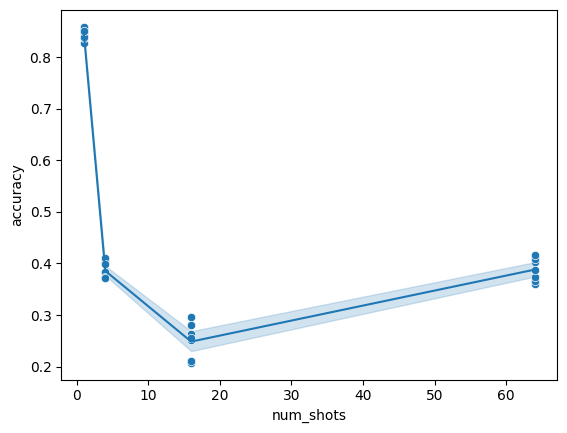

In [36]:

sns.lineplot(data=results, x="num_shots", y="accuracy")
sns.scatterplot(data=results, x="num_shots", y="accuracy")

<AxesSubplot:xlabel='num_shots', ylabel='accuracy'>

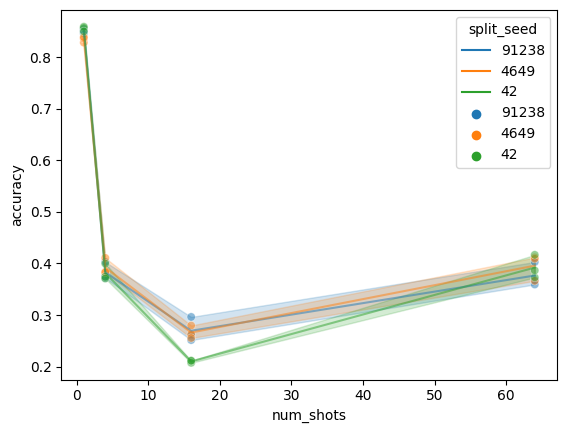

In [41]:
results["split_seed"] = results["split_seed"].astype(str)
sns.lineplot(data=results, x="num_shots", y="accuracy", hue="split_seed", alpha=0.5)
sns.scatterplot(data=results, x="num_shots", y="accuracy", hue="split_seed", alpha=0.5)

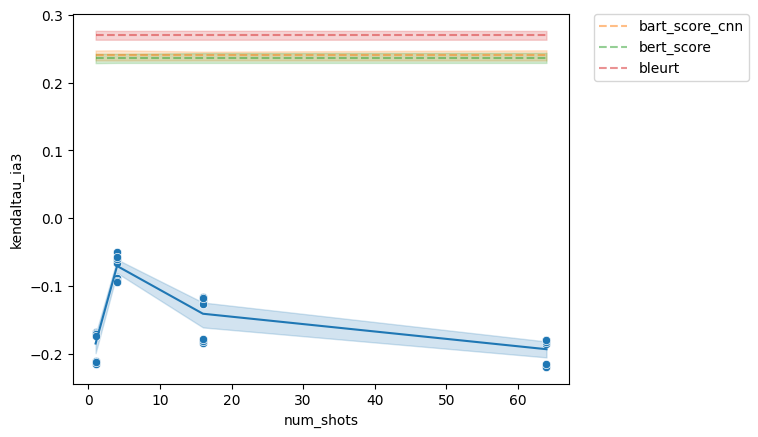

In [37]:
# 9 points each
sns.lineplot(data=results, x="num_shots", y=f"kendaltau_ia3")
sns.scatterplot(data=results, x="num_shots", y=f"kendaltau_ia3")

for metric in metrics_corr[1::2]:
    sns.lineplot(data=results, x="num_shots", y=metric, ls="--", label=metric[10:], alpha=0.5)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

<AxesSubplot:xlabel='num_shots', ylabel='accuracy'>

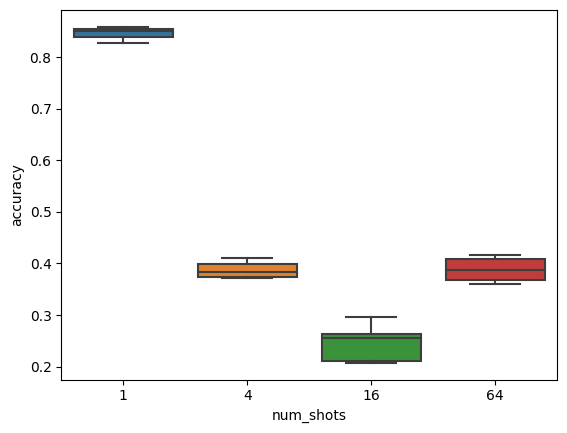

In [38]:
sns.boxplot(data=results, x="num_shots", y=f"accuracy")

<AxesSubplot:xlabel='num_shots', ylabel='kendaltau_ia3'>

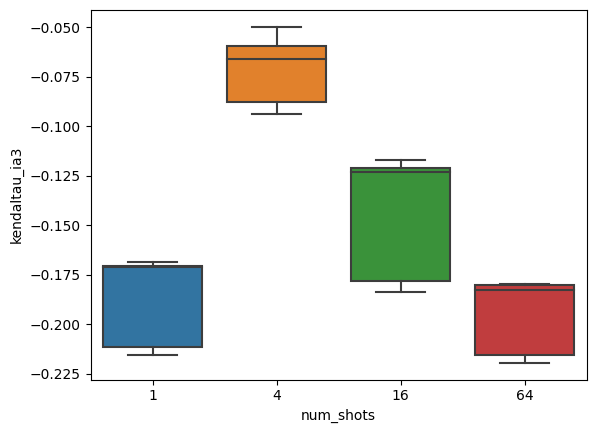

In [39]:
sns.boxplot(data=results, x="num_shots", y=f"kendaltau_ia3")